## 03_Recherche des meilleurs hyperparamètres pour la prédiction de la vitesse
On cherche à trouver les meilleurs hyperparamètres grace à Hyperopt pour rendre le reservoir plus pertinent et adapté à nos données. 

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy import ESN
import glob
import re

In [3]:
# Chargement des données
data_dir = "../projet_data/data"
files = glob.glob(f"{data_dir}/course*.csv")

def course_idx(path):
    m = re.search(r"course(\d+)\.csv", path)
    return int(m.group(1)) if m else 1e9

files = sorted(files, key=course_idx)
train_files = files[0:11]
print("Fichiers d'entraînement:", [f.split("/")[-1] for f in train_files])

X_train_list_raw = []
y_train_list_raw = []

for fp in train_files:
    df = pd.read_csv(fp, sep=';', decimal=',').fillna(0)
    df["Time"] = pd.to_datetime(df["Time"])
    df["t_elapsed"] = (df["Time"] - df["Time"].iloc[0]).dt.total_seconds()
    total_time = df["t_elapsed"].iloc[-1]
    df["time_remaining"] = total_time - df["t_elapsed"]
    km_total = df["km"].iloc[-1]
    df["km_total"] = km_total

    Xi = df[["km", "speed_kmh", "FC", "km_total"]].values
    yi = df["time_remaining"].values.reshape(-1, 1)

    delta_t = 30
  # nombre de pas dans le futur

    X_train_list_raw.append(Xi[:-delta_t])
    y_train_list_raw.append(Xi[delta_t:, 1].reshape(-1, 1))

print("Nombre de courses:", len(X_train_list_raw))

Fichiers d'entraînement: ['data\\course1.csv', 'data\\course2.csv', 'data\\course3.csv', 'data\\course4.csv', 'data\\course5.csv', 'data\\course6.csv', 'data\\course7.csv', 'data\\course8.csv', 'data\\course9.csv', 'data\\course10.csv', 'data\\course11.csv']
Nombre de courses: 11


In [4]:
# Normalisation simple (0-1)

X_concat = np.vstack(X_train_list_raw)
y_concat = np.vstack(y_train_list_raw)

X_max = X_concat.max(axis=0)
y_max = y_concat.max()

Xn_train_list = [Xi / X_max for Xi in X_train_list_raw]
Yn_train_list = [yi / y_max for yi in y_train_list_raw]

### Hyperopt

Dans cette section, nous optimisons automatiquement les hyperparamètres clés de l'ESN (`units`, `sr`, `lr`, `ridge`) à l'aide de Hyperopt (recherche aléatoire).

In [5]:
# %pip install "reservoirpy[hyper]"
import json
import numpy as np

from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.observables import nrmse, rsquare
from reservoirpy.hyper import parallel_research, plot_hyperopt_report

### Split entraînement/validation

Comme précédement on choisi les courses 3 à 9 comme courses d'entrainement et les autres courses comme courses de test. 

In [6]:
# Split par courses entières: train = courses 3..9, test = autres

train_ids = list(range(3, 10)) 
train_files = [f for f in files if course_idx(f) in train_ids]
train_course_ids = [course_idx(f) for f in train_files]

test_files  = [f for f in files if course_idx(f) not in train_ids]

print("Courses entraînement:", [f.split("/")[-1] for f in train_files])
print("Courses test:", [f.split("/")[-1] for f in test_files])


def build_sequences(file_list, delta_t):
    X_list, y_list = [], []
    for fp in file_list:
        df = pd.read_csv(fp, sep=';', decimal=',').fillna(0)
        df["Time"] = pd.to_datetime(df["Time"])
        df["t_elapsed"] = (df["Time"] - df["Time"].iloc[0]).dt.total_seconds()
        total_time = df["t_elapsed"].iloc[-1]
        df["time_remaining"] = total_time - df["t_elapsed"]
        km_total = df["km"].iloc[-1]
        df["km_total"] = km_total
        Xi = df[["km", "speed_kmh", "FC", "km_total"]].values
        # Cible = vitesse future à t+delta_t
        X_list.append(Xi[:-delta_t])
        y_list.append(Xi[delta_t:, 1].reshape(-1, 1))
    return X_list, y_list

# Reconstruire les séquences brutes
X_train_list_raw, y_train_list_raw = build_sequences(train_files, delta_t)
X_test_list_raw,  y_test_list_raw  = build_sequences(test_files,  delta_t)

# Normalisation basée uniquement sur les stats d'entraînement
X_concat = np.vstack(X_train_list_raw)
y_concat = np.vstack(y_train_list_raw)

X_max = X_concat.max(axis=0)
y_max = y_concat.max()

X_scale = np.where(X_max == 0, 1.0, X_max)
y_scale = y_max if y_max != 0 else 1.0

Xn_train_list = [Xi / X_scale for Xi in X_train_list_raw]
Yn_train_list = [yi / y_scale for yi in y_train_list_raw]
Xn_test_list  = [Xi / X_scale for Xi in X_test_list_raw]
Yn_test_list  = [yi / y_scale for yi in y_test_list_raw]

# Validation pour Hyperopt: sélectionner des courses entières parmi le set d'entraînement (ex: course 9)
val_ids = [3,6,9]  

X_train_list, Y_train_list = [], []
X_val_list, Y_val_list = [], []

for Xi, yi, cid in zip(Xn_train_list, Yn_train_list, train_course_ids):
    if cid in val_ids:
        X_val_list.append(Xi)
        Y_val_list.append(yi)
    else:
        X_train_list.append(Xi)
        Y_train_list.append(yi)

print(
    f"Courses train={len(Xn_train_list)} (dont val={len(X_val_list)}) | courses test={len(Xn_test_list)}"
)
if X_train_list:
    print("Exemple shapes train:", X_train_list[0].shape, Y_train_list[0].shape)
if X_val_list:
    print("Exemple shapes val:", X_val_list[0].shape, Y_val_list[0].shape)

Courses entraînement: ['data\\course3.csv', 'data\\course4.csv', 'data\\course5.csv', 'data\\course6.csv', 'data\\course7.csv', 'data\\course8.csv', 'data\\course9.csv']
Courses test: ['data\\course1.csv', 'data\\course2.csv', 'data\\course10.csv', 'data\\course11.csv', 'data\\course12.csv']
Courses train=7 (dont val=3) | courses test=5
Exemple shapes train: (2772, 4) (2772, 1)
Exemple shapes val: (1737, 4) (1737, 1)


### Définition de la fonction objectif

La fonction `objective` construit un ESN à partir d'un set d'hyperparamètres, l'entraîne sur les sous-séquences
d'entraînement, puis évalue une perte (NRMSE) sur les sous-séquences de validation. 

On répète plusieurs instances pour lisser l'aléatoire du réservoir.

In [7]:
def _eval_on_validation(model, X_val_list, Y_val_list, warmup=30):
    # Génère des prédictions sur la validation et calcule une NRMSE globale
    preds_cat = []
    y_cat = []
    for Xv, Yv in zip(X_val_list, Y_val_list):
        model.reset()
        pv = model.run(Xv)
        # On ignore warmup du début pour aligner proprement
        if warmup > 0:
            pv = pv[warmup:]
            y_align = Yv[warmup:]
        else:
            y_align = Yv
        # Sécurité si séquence trop courte
        n = min(len(pv), len(y_align))
        if n <= 0:
            continue
        preds_cat.append(pv[:n])
        y_cat.append(y_align[:n])
    if not preds_cat:
        return np.nan
    P = np.vstack(preds_cat)
    Y = np.vstack(y_cat)
    # Données déjà normalisées -> norm_value = 1.0 convient (amplitude ~1)
    return nrmse(Y, P, norm_value=1.0)


def _to_scalar(x):
    # Convertit les valeurs potentiellement emballées (list/tuple/ndarray) en scalaire
    if isinstance(x, (list, tuple)):
        return _to_scalar(x[0]) if len(x) > 0 else x
    try:
        import numpy as _np
        if isinstance(x, _np.ndarray):
            return _to_scalar(x.item() if x.shape == () else x[0])
    except Exception:
        pass
    return x


def objective(dataset, config, *, units, sr, lr, ridge, seed):
    X_tr_list, Y_tr_list, X_v_list, Y_v_list = dataset
    instances = int(_to_scalar(config.get("instances_per_trial", 3)))
    warmup = int(_to_scalar(config.get("warmup", 30)))

    # Hyperparamètres potentiellement retournés sous forme de listes -> conversion robuste
    units = int(_to_scalar(units))
    sr = float(_to_scalar(sr))
    lr = float(_to_scalar(lr))
    ridge = float(_to_scalar(ridge))
    var_seed = int(_to_scalar(seed))

    losses = []
    for _ in range(instances):
        reservoir = Reservoir(units=units, sr=sr, lr=lr, seed=var_seed)
        readout = Ridge(ridge=ridge)
        model = reservoir >> readout

        # Entraînement sur listes de séquences
        model.fit(X_tr_list, Y_tr_list, warmup=warmup)

        # Évaluation sur validation
        loss = _eval_on_validation(model, X_v_list, Y_v_list, warmup=warmup)
        losses.append(loss)
        var_seed += 1

    return {"loss": float(np.nanmean(losses))}

### Espace de recherche et configuration Hyperopt

On utilise une recherche aléatoire (Random Search). On fixe certains paramètres et on explore `units`, `sr`, `lr`, `ridge`.

On choisit 200 évaluations maximales (`hp_max_evals`) pour explorer l'espace de recherche. Pour chaque combinaison d'hyperparamètres testée, on effectue 5 instances (`instances_per_trial`) avec des graines aléatoires différentes afin de réduire l'influence de l'initialisation aléatoire du réservoir et obtenir une estimation plus robuste de la performance.

Les plages de recherche sont :
- **units** : 100, 200 ou 300 neurones dans le réservoir
- **sr** (spectral radius) : entre 0.5 et 1.5 
- **lr** (leak rate) : entre 0.01 et 0.5 
- **ridge** (régularisation) : entre 1e-7 et 1e-3 

In [8]:
hyperopt_config = {
    "exp": "esn_speed_forecast",
    "hp_max_evals": 200,
    "hp_method": "random",
    "seed": 42,
    "instances_per_trial": 5,
    "warmup": 30,
    "hp_space": {
        "units": ["choice", [100, 200, 300]],
        "sr": ["loguniform", 0.5, 1.5],
        "lr": ["loguniform", 1e-2, 0.5],
        "ridge": ["loguniform", 1e-7, 1e-3],
        "seed": ["choice", 42]
    }
}

# Sauvegarde en JSON (format supporté universellement)
config_path = f"{hyperopt_config['exp']}.config.json"
with open(config_path, "w", encoding="utf-8") as f:
    json.dump(hyperopt_config, f)
print("Configuration écrite dans:", config_path)

Configuration écrite dans: esn_speed_forecast.config.json


In [9]:
dataset = (X_train_list, Y_train_list, X_val_list, Y_val_list)
best = parallel_research(objective, dataset, config_path, ".")
print("Meilleurs hyperparamètres:")
print(best)

100%|██████████| 200/200 [07:57<00:00,  2.39s/trial, best loss=0.0608]

Meilleurs hyperparamètres:
({'units': [100, 200, 300], 'sr': np.float64(0.6732165121610824), 'lr': np.float64(0.16073364247864863), 'ridge': np.float64(0.0008333340733122706), 'seed': 42}, 0.06081792505477605)


### Rapport et interprétation

On affiche le rapport d'Hyperopt pour visualiser l'influence de `lr`, `sr` et `ridge` sur la performance (loss).
Le choix efficace des hyperparamètres à optimiser repose sur un compromis entre la taille de l’espace de recherche, la variance intrinsèque du modèle et le nombre d'évaluations.

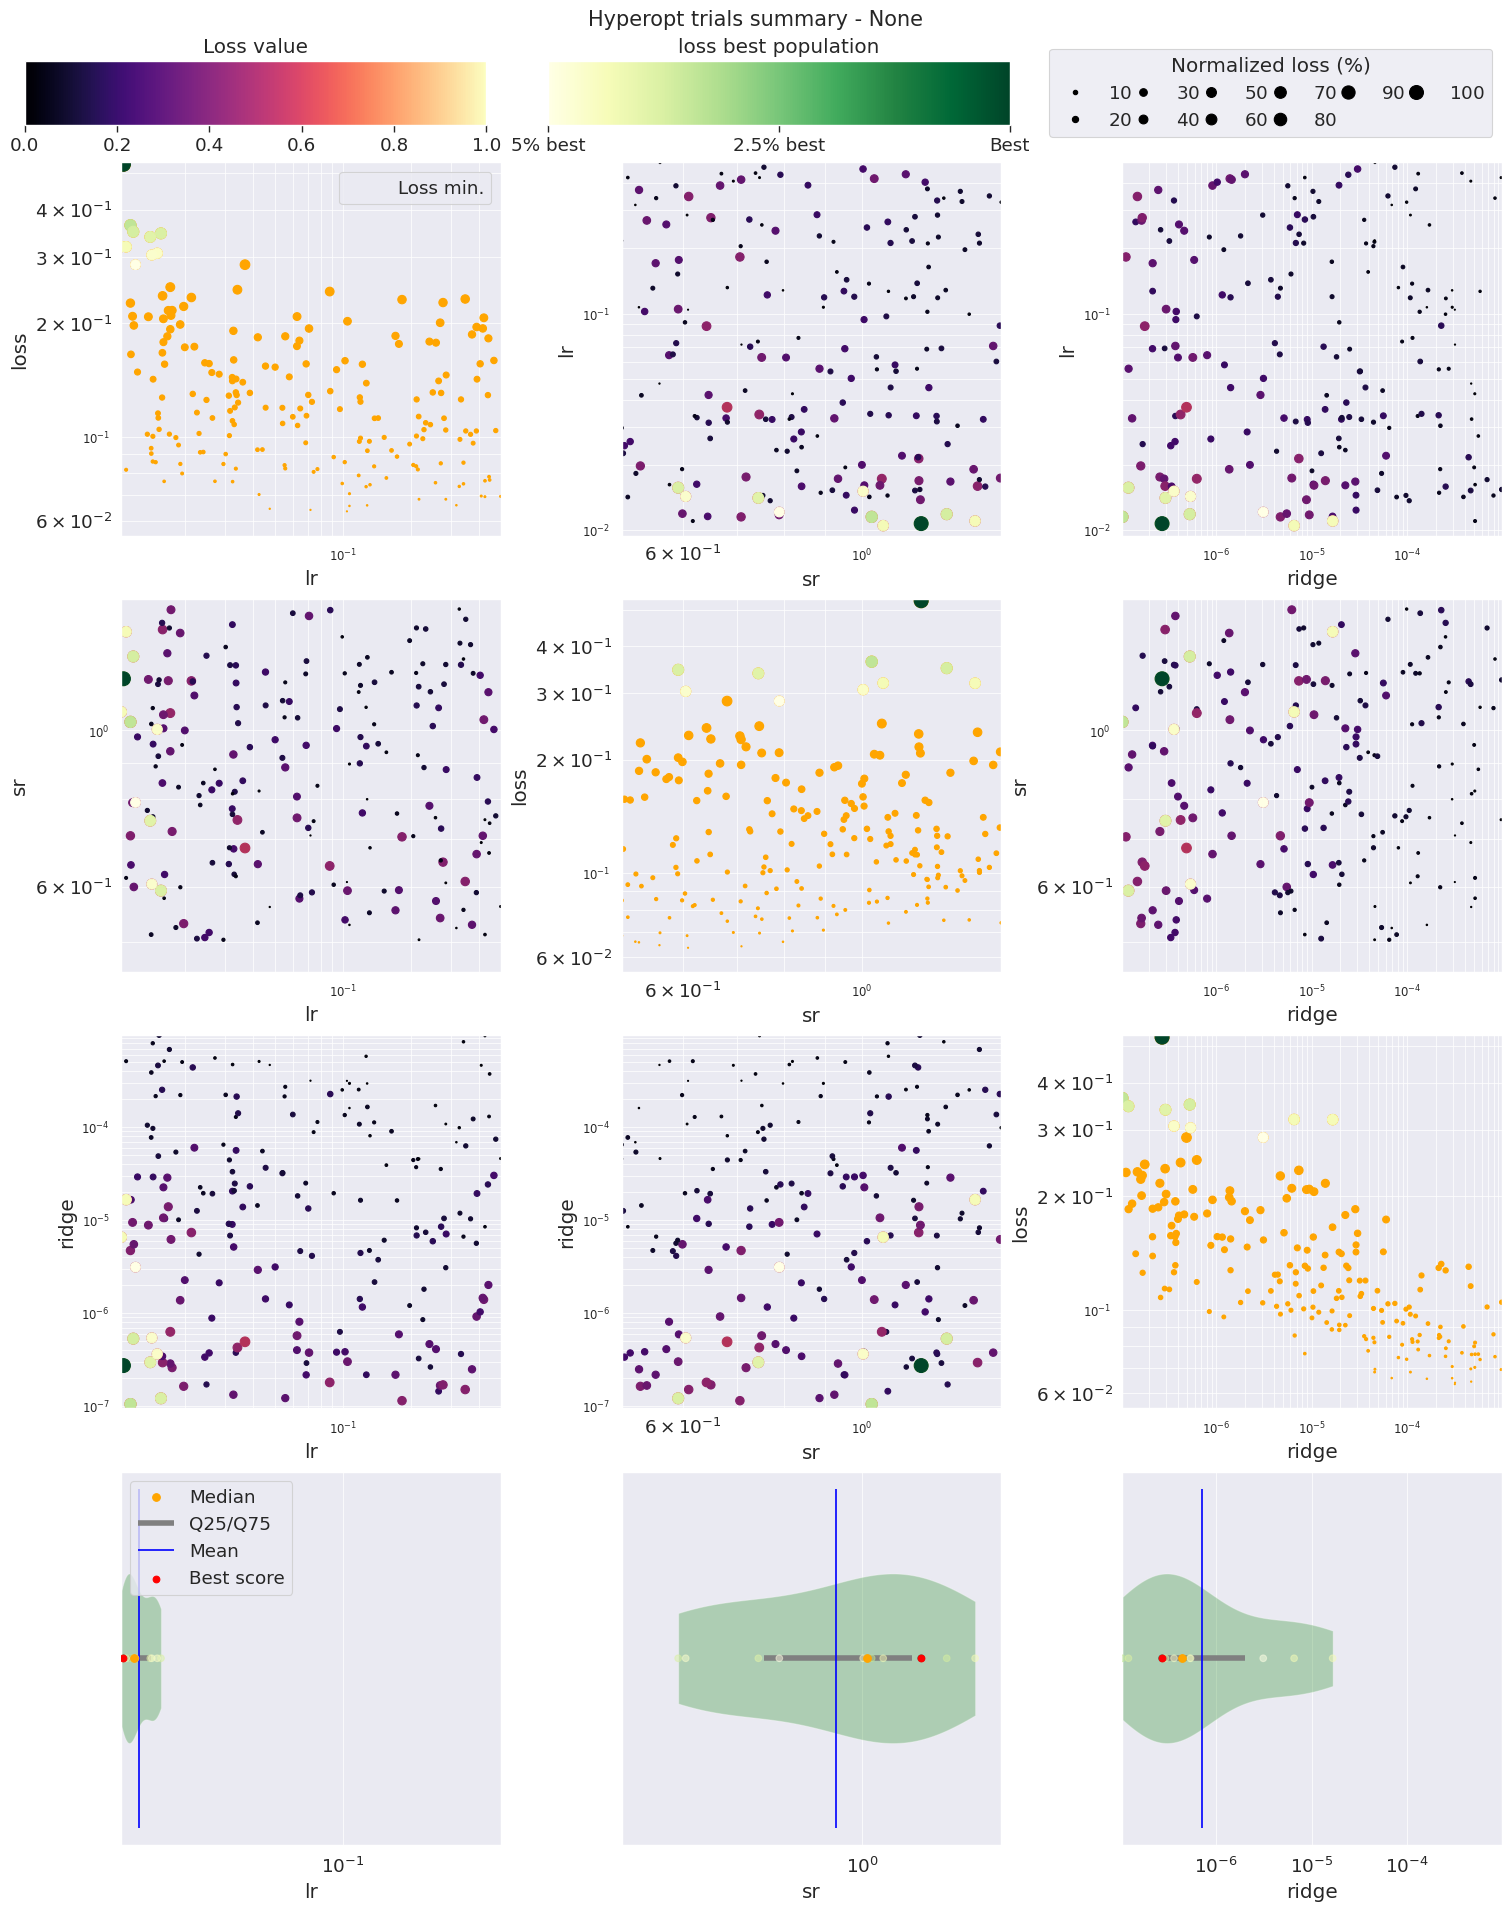

In [17]:
fig = plot_hyperopt_report(hyperopt_config["exp"], ("lr", "sr", "ridge"), metric="loss")
fig

Les nuages de points reprèsentent en chaque point une combinaison d'hyperparamètres testée
- La couleur indique la qualité : **vert** = meilleure performance (loss faible), **rouge/orange** = moins bonne performance
- Les plages optimales se trouve là où sont concentrés les points verts

Les boites à moustache permettent de conclure sur les meilleurs hyperparamètres trouvés 


Ici on observe : 
- **lr (leak rate)** faible = mémoire longue
- **sr (spectral radius)** median = stabilité
- **Corrélations** : on voit que les 3 paramètre semblent corrélés avec loss

## Ré-entrainement du modèle avec les meilleurs hyper-paramètres 
On relance une initialisation et un entrainement du reservoir avec les meilleurs paramètres qui ont été trouvé et on test sur une courses non utilisée pour l'entrainement. 

In [14]:
# Extraction des meilleurs hyperparamètres
best_params = best[0]
best_loss = best[1]

print(f"Meilleure loss de validation: {best_loss:.6f}")
print(f"Hyperparamètres optimaux:")
print(f"  - units: {best_params['units']}")
print(f"  - sr: {best_params['sr']:.6f}")
print(f"  - lr: {best_params['lr']:.6f}")
print(f"  - ridge: {best_params['ridge']:.8f}")

# Création du modèle optimisé
# Note: 'units' est une liste dans votre cas, on prend le premier élément
units_opt = best_params['units'][0] if isinstance(best_params['units'], list) else best_params['units']

reservoir_opt = Reservoir(
    units=units_opt,
    sr=float(best_params['sr']),
    lr=float(best_params['lr']),
    seed=42
)
readout_opt = Ridge(ridge=float(best_params['ridge']))
esn_optimized = reservoir_opt >> readout_opt

# Entraînement sur TOUTES les données d'entraînement (train + val)
# Pour maximiser les performances finales
X_all_train = X_train_list + X_val_list
Y_all_train = Y_train_list + Y_val_list

warmup = 30
esn_optimized.fit(X_all_train, Y_all_train, warmup=warmup)

print("\nRéservoir optimisé initialisé:", reservoir_opt.initialized)
print("Readout optimisé initialisé:", readout_opt.initialized)

Meilleure loss de validation: 0.060818
Hyperparamètres optimaux:
  - units: [100, 200, 300]
  - sr: 0.673217
  - lr: 0.160734
  - ridge: 0.00083333

Réservoir optimisé initialisé: True
Readout optimisé initialisé: True


In [15]:
# Prédiction sur une course de test (course 12 par exemple)
test_file = files[11] if len(files) > 11 else test_files[0]
print("Fichier de test:", test_file.split("/")[-1])

test_df = pd.read_csv(test_file, sep=';', decimal=',').fillna(0)
test_df["Time"] = pd.to_datetime(test_df["Time"])
test_df["t_elapsed"] = (test_df["Time"] - test_df["Time"].iloc[0]).dt.total_seconds()
total_time_test = test_df["t_elapsed"].iloc[-1]
test_df["time_remaining"] = total_time_test - test_df["t_elapsed"]
km_total_test = test_df["km"].iloc[-1]
test_df["km_total"] = km_total_test

X_test_raw = test_df[["km", "speed_kmh", "FC", "km_total"]].values

# Normalisation avec les mêmes facteurs que l'entraînement
X_test_n = X_test_raw / X_scale

# Prédiction
esn_optimized.reset()
y_pred_n = esn_optimized.run(X_test_n[:-delta_t])
y_pred = y_pred_n * y_scale
y_real = X_test_raw[delta_t:, 1].reshape(-1, 1)

print("Shapes pred/real:", len(y_pred), len(y_real))

Fichier de test: data\course12.csv
Shapes pred/real: 3537 3537


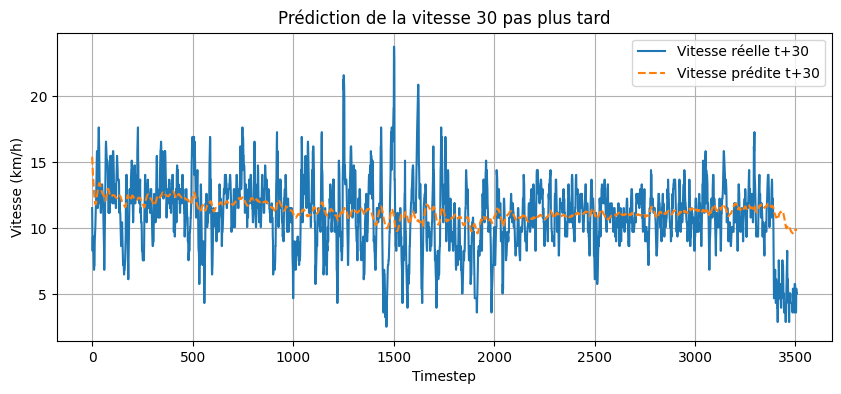


NRMSE sur le test: 0.105112


In [16]:
# Visualisation de la prédiction
start = warmup
# Définition des indices sécurisés
real_start = max(start - delta_t, 0)
end_common = min(len(y_pred), len(y_real) - real_start, len(y_pred) - start)
n = end_common

if n <= 0:
    print(f"Pas assez de points pour tracer (delta_t={delta_t}, warmup={warmup}).")
else:
    plt.figure(figsize=(10,4))

    y_real_shifted = y_real[real_start : real_start + n]
    y_pred_slice = y_pred[start : start + n]

    plt.plot(y_real_shifted, label=f"Vitesse réelle t+{delta_t}")
    plt.plot(y_pred_slice, "--", label=f"Vitesse prédite t+{delta_t}")
    plt.xlabel("Timestep")
    plt.ylabel("Vitesse (km/h)")
    plt.title(f"Prédiction de la vitesse {delta_t} pas plus tard")
    plt.legend()
    plt.grid(True)
    plt.show()

    
    # Calcul de la NRMSE sur le test
    nrmse_test = nrmse(y_real_shifted, y_pred_slice, norm_value=y_real_shifted.max())
    print(f"\nNRMSE sur le test: {nrmse_test:.6f}")

### Conclusion et interprétation des résultats

- Résultat avant optimisation (NRMSE): **0.104780**
- Résultat après optimisation (NRMSE): **0.105112**
- Écart: **+0.000332** (≈ +0.3%)

Les performances sont pratiquement équivalentes et l'optimisation n'apporte pas de gain mesurable ici.

L’absence de gain peut s’expliquer par la variance d’initialisation, un espace de recherche limité et un prétraitement simple. Pour progresser, il faudrait intensifier la recherche, élargir les hyperparamètres, et renforcer la validation. Nous avons testé plusieurs configurations mais celle-ci s'est avéré être la meilleure pour un temps de calcul raisonnable. 